In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm
import math
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
%matplotlib inline

In [31]:
# Read the taxizone shapefile
sf = shapefile.Reader("Data/Shapefiles/geo_export_7766f064-29c1-4e13-b2d9-2e368707ff51.shp")

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

# look at shapefile and merge with longitude and latitude
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("location_i"), on="location_i")

In [64]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["location_i", "longitude", "latitude"])

def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

def draw_region_map(ax, sf, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'Staten Island':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'EWR':5, 'Brooklyn':6}
    reg_x = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    reg_y = {'Staten Island':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'EWR':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values()))) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
        cm=plt.get_cmap('Reds')
        #sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        #sm.set_array([])
        #plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8), \
        #             boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    ax.set_facecolor(ocean)
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center', verticalalignment='center',
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000), horizontalalignment='center', 
                     verticalalignment='center',bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12)       

    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])


def draw_zone_map(ax, sf, heat={}, text=[], arrows=[]):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    col = continent
    
    # colorbar
    if len(heat) != 0:

         # Separate positive and negative values for different color maps
        pos_norm = mpl.colors.Normalize(vmin=0, vmax=max(heat.values()))
        neg_norm = mpl.colors.Normalize(vmin=min(heat.values()), vmax=0)

        # Define two color maps
        pos_cm = plt.get_cmap('Reds')
        neg_cm = plt.get_cmap('Blues_r')



        # Create and set the ScalarMappable objects for colorbars
        pos_sm = plt.cm.ScalarMappable(cmap=pos_cm, norm=pos_norm)
        neg_sm = plt.cm.ScalarMappable(cmap=neg_cm, norm=neg_norm)
        pos_sm.set_array([])
        neg_sm.set_array([])

        # Display the colorbars
        plt.colorbar(pos_sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
        plt.colorbar(neg_sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['location_i']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = (1, 1, 1, 1)
        else:
            if loc_id not in heat:
                col = (1, 1, 1, 1)  # Default color if no data
            else:
                heat_value = heat[loc_id]
                if heat_value > 0:
                    col = pos_cm(pos_norm(heat_value))
                elif heat_value < 0:
                    col = neg_cm(neg_norm(heat_value))
                else:
                    col = (1, 1, 1, 1)


        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['shape_area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            #plt.text(x+0.01, y-0.01, str(loc_id), fontsize=12, color="white", bbox=dict(facecolor='black', alpha=0.5))
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.5), color="white", fontsize=12,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(sf)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [105]:
def run_zone_level_regression_distance(data, PULocationID):
    """
    Run the regression for a given PULocationID, including time fixed effects,
    and return the results with heteroskedasticity-robust standard errors.
    
    Parameters:
    data (DataFrame): The panel data.
    PULocationID (int): The unique identifier for the location.
    
    Returns:
    dict: A dictionary with regression results for the given PULocationID.
    """
    # Subset the data for the current PULocationID
    temp_data = data[data['PULocationID'] == PULocationID]
    if temp_data.empty:
        print(f"The DataFrame is empty after filtering for {PULocationID}.")
    for col in ["tmax_obs", "trip_distance_mean"]:
        if temp_data[col].nunique() <= 1:
            print(f"{col} has no variation for {PULocationID}.")
    
    
    
    # if over half of "dynamic_tourism" is na then adapt formula:

    model_formula = 'trip_distance_mean ~ 1 + tmax_obs + pr_obs + windspeed_obs + Weekday_index + holiday + cheby_1 + cheby_2 + cheby_3 + cheby_4 + cheby_5 + C(Year_fact)'


    # Fit the model from formula
    model = sm.formula.ols(formula=model_formula, data=temp_data)
    results = model.fit(cov_type='HC3')  
    # Extract results and return them in a dictionary
    return {
        'PULocationID': PULocationID,
        'Coefficient_tmax_obs': results.params.get('tmax_obs', float('nan')),
        'CI_lower': results.conf_int().loc['tmax_obs'][0] if 'tmax_obs' in results.params else float('nan'),
        'CI_upper': results.conf_int().loc['tmax_obs'][1] if 'tmax_obs' in results.params else float('nan'),
        'p_value_tmax_obs': results.pvalues.get('tmax_obs', float('nan')),
        'num_observations': results.nobs,
    }

In [97]:
pooled_regression = pd.read_csv("Data/Pooled_data/data_regression_PU.csv")
pooled_regression["total_amount_mean"] = pooled_regression['total_amount_mean'].fillna(pooled_regression['base_fare_mean'])


In [112]:
# Load the data over 20 degrees
panel_data = pooled_regression[pooled_regression["tmax_obs"] >= 20]


# First exclude zones 0 and unknown zones

panel_data = panel_data[~panel_data["PULocationID"].isin([0, 264, 265])]


# Add column where average trip number per day is calculated for each zone
panel_data["trip_count_median"] = panel_data.groupby(["PULocationID"])["trip_number"].transform("median")
# 2nd : exclude zones with less than 5 daily trips on average
panel_data = panel_data[panel_data["trip_count_median"] >= 5]


# only weekends : where weekday index is either 5 or 6


#panel_data = panel_data[panel_data["Weekday_index"].isin([5, 6])]
#panel_data = panel_data[~panel_data["Weekday_index"].isin([5, 6])]


# Get unique PULocationIDs and apply the regression function to each
unique_ids = panel_data['PULocationID'].unique()
results = [run_zone_level_regression_distance(panel_data, id) for id in unique_ids]

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

sign_results = results_df[results_df["p_value_tmax_obs"] <= 0.05]


In [113]:
# merge df of results subset ( significant at least at 10% level)
plot_mobility_heat = sign_results.merge(df_loc[["borough", "location_i", "zone"]], left_on="PULocationID", right_on="location_i").drop("PULocationID", axis=1)
plot_mobility_heat["Coefficient_tmax_obs"] = plot_mobility_heat["Coefficient_tmax_obs"]

top3_sign= plot_mobility_heat.sort_values(by=['Coefficient_tmax_obs'], ascending=False).set_index("location_i").head(3)
bottom3_sign= plot_mobility_heat.sort_values(by=['Coefficient_tmax_obs'], ascending=True).set_index("location_i").head(3)

# concatenate the top and bottom 3
top_bottom = pd.concat([top3_sign, bottom3_sign])

mobility_response = dict(zip(plot_mobility_heat['location_i'].tolist(), plot_mobility_heat['Coefficient_tmax_obs'].tolist()))

c:\Anaconda\anaconda3\envs\dl_intro\Lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


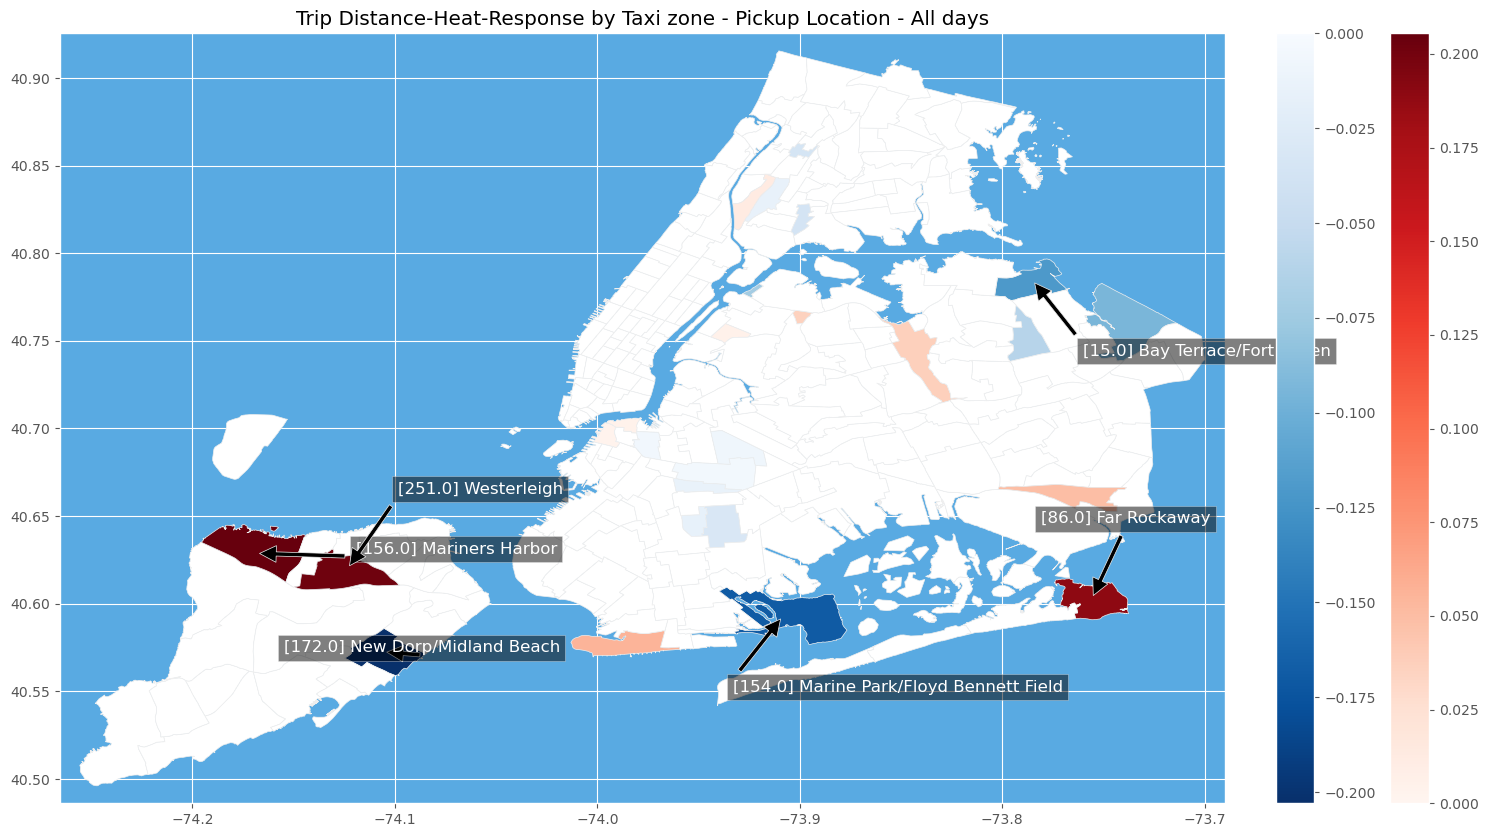

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18,10))
ax.set_title("Trip Distance-Heat-Response by Taxi zone - Pickup Location - All days")

draw_zone_map(ax, sf, heat=mobility_response, text=top_bottom.index.tolist())

plt.show()

In [115]:
sign_results

,PULocationID,Coefficient_tmax_obs,CI_lower,CI_upper,p_value_tmax_obs,num_observations
4,8.0,-0.072169,-0.118172,-0.026165,0.002107,903.0
5,9.0,-0.060589,-0.118459,-0.002719,0.040165,856.0
11,15.0,-0.119869,-0.211303,-0.028435,0.010185,803.0
27,33.0,0.002716,0.000231,0.005200,0.032167,918.0
48,55.0,0.055618,0.010440,0.100797,0.015827,918.0
54,61.0,-0.005541,-0.009993,-0.001089,0.014707,918.0
55,62.0,-0.014392,-0.023142,-0.005642,0.001266,918.0
58,66.0,0.004170,0.001559,0.006782,0.001749,918.0
61,69.0,-0.015217,-0.025483,-0.004950,0.003674,918.0
63,71.0,-0.031283,-0.062347,-0.000218,0.048412,918.0
